# Conditional Synthetic Return Generation using DDPM

This notebook implements a vanilla Denoising Diffusion Probabilistic Model (DDPM), based on the framework introduced by Ho et al. (2020), for generating synthetic financial return sequences using historical S&P 500 data. The goal is to evaluate the ability of diffusion models to reproduce key **stylized facts** of financial time series, including:

- Heavy tails  
- Volatility clustering  
- Non-zero skewness and excess kurtosis  

These properties are well-established in the financial literature (Cont, 2001) and serve as the benchmark for assessing the realism of generated sequences.

---

## Workflow Overview

The notebook follows this pipeline:

- Preprocessing and transforming price data into log return sequences (Cont, 2001)
- Segmenting returns into 60-day overlapping sequences
- Defining a simple MLP-based denoising model
- Training the model using a linear diffusion schedule (Ho et al., 2020)
- Generating synthetic return sequences from Gaussian noise
- Evaluating statistical and visual similarity to real data (histograms, ACFs, KS tests)

This work positions diffusion models as a **modern generative alternative** to classical time series models such as GARCH, with the potential for richer scenario simulation and stress testing.

---

## References

- Ho, J., Jain, A., & Abbeel, P. (2020). *Denoising Diffusion Probabilistic Models*. NeurIPS. [arXiv:2006.11239](https://arxiv.org/abs/2006.11239)  
- Cont, R. (2001). *Empirical properties of asset returns: stylized facts and statistical issues*. Quantitative Finance, 1(2), 223–236.  
- Sohl-Dickstein, J., Weiss, E., Maheswaranathan, N., & Ganguli, S. (2015). *Deep Unsupervised Learning using Nonequilibrium Thermodynamics*. [arXiv:1503.03585](https://arxiv.org/abs/1503.03585)  


In [3]:
!pip install yfinance numpy pandas matplotlib scikit-learn torch


In [4]:
!pip install pytorch-forecasting pytorch-lightning


## Data Loading and Preprocessing

We begin by loading historical daily closing prices of the S&P 500 index from a local CSV file. The dataset is cleaned and transformed into log returns, which are standard in financial modelling due to their desirable properties such as time-additivity and approximate normality over short intervals.

To prepare the data for the diffusion model, we segment the log returns into overlapping sequences of 60 trading days. Each sequence is treated as an independent training sample. This window length captures short-term dynamics and aligns with common practices in volatility modeling and scenario generation.

The resulting tensor `X` has shape (N, 60, 1), where:
- `N` is the number of sequences
- `60` is the sequence length (time steps)
- `1` is the channel dimension (used by PyTorch models)

This format is required for feeding data into the DDPM architecture.


In [29]:
import pandas as pd
import numpy as np

# Load pre-downloaded data
data = pd.read_csv("sp500_data.csv", index_col=0, parse_dates=True)
data.index = pd.to_datetime(data.index)
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
data = data[['Close']]

# Compute log returns
returns = np.log(data['Close'] / data['Close'].shift(1)).dropna() * 100

# Create sequences of 60 days (for DDPM)
sequence_length = 60
X = np.array([returns[i:i+sequence_length].values for i in range(len(returns) - sequence_length)])
X = X[..., np.newaxis]  # (N, 60, 1)

print(f"Shape of return sequences: {X.shape}")



Shape of return sequences: (3712, 60, 1)


In [30]:
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
import random
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Split the dataset into training and validation sets
X_train, X_val = train_test_split(X, test_size=0.1, random_state=42)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

# Create DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor)
val_dataset = TensorDataset(X_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Check the shapes
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")
print(f"Train batch shape: {next(iter(train_loader))[0].shape}")


Training samples: 3340, Validation samples: 372
Train batch shape: torch.Size([64, 60, 1])


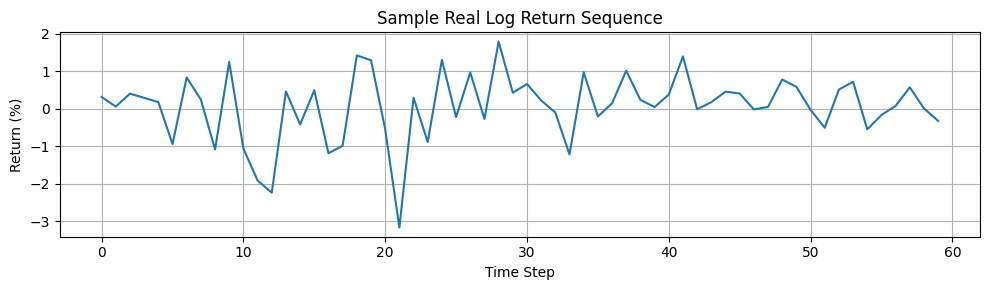

In [31]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 3))
plt.plot(X[0])
plt.title("Sample Real Log Return Sequence")
plt.xlabel("Time Step")
plt.ylabel("Return (%)")
plt.grid(True)
plt.tight_layout()
plt.savefig("real_sample_sequence.pdf")
plt.show()



In [32]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Inspect shape
print(next(iter(loader))[0].shape)  # (batch_size, seq_length, 1)


torch.Size([32, 60, 1])


In [33]:
# Assume X is already defined as shape (3712, 60, 1)
X_tensor = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [34]:
# Convert log returns to 60-day sequences for DDPM training
sequence_length = 60

# 'returns' should have been computed earlier from S&P500 Close prices
# Shape each window as (60, 1) and stack into a single array
X = np.array([
    returns[i:i + sequence_length].values 
    for i in range(len(returns) - sequence_length)
])
X = X[..., np.newaxis]  # Add channel dimension to get shape (N, 60, 1)

# Confirm shape and type
print(f"Shape of X: {X.shape}")  # Should be something like (3712, 60, 1)
print(f"Data type: {X.dtype}")


Shape of X: (3712, 60, 1)
Data type: float64


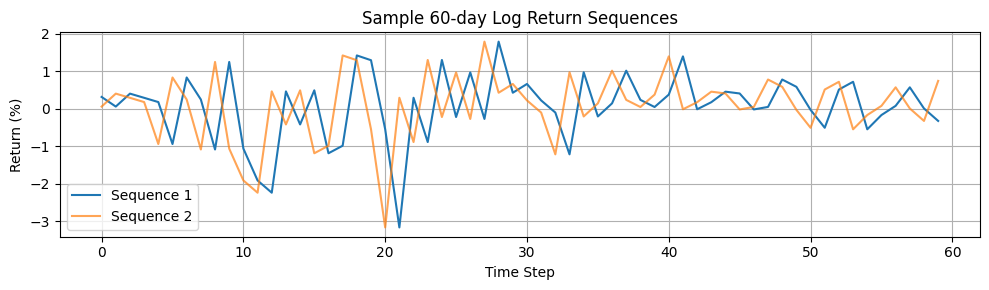

In [35]:
# Plot a few sequences to verify visually
plt.figure(figsize=(10, 3))
plt.plot(X[0].squeeze(), label="Sequence 1")
plt.plot(X[1].squeeze(), label="Sequence 2", alpha=0.7)
plt.title("Sample 60-day Log Return Sequences")
plt.xlabel("Time Step")
plt.ylabel("Return (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("training_sequences_examples.pdf")
plt.show()


In [36]:
!pip install torchsummary


In [37]:
import torch
import torch.nn as nn
from torchsummary import summary

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define Denoising MLP Model
class DenoiseMLP(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),                  # (batch, seq_len, 1) -> (batch, seq_len)
            nn.Linear(seq_len, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, seq_len)       # Output shape: (batch, seq_len)
        )

    def forward(self, x):
        return self.model(x).unsqueeze(-1)  # Restore shape: (batch, seq_len, 1)

# Convert X to torch tensor and move to device
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)

# Model setup
seq_len = X_tensor.shape[1]
model = DenoiseMLP(seq_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Print model summary
print("Model Summary:")
summary(model, input_size=(seq_len, 1))

# Save architecture to file (optional)
with open("ddpm_model_architecture.txt", "w") as f:
    f.write(str(model))




Using device: cuda
Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                   [-1, 60]               0
            Linear-2                  [-1, 128]           7,808
              ReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 60]           7,740
Total params: 32,060
Trainable params: 32,060
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.12
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


In [38]:
# Define diffusion schedule
timesteps = 100  # Can be changed depending on training stability
betas = torch.linspace(1e-4, 0.02, timesteps).to(device)  # Linear beta schedule
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

# Forward process: add noise to data at random timesteps
def q_sample(x_start, t, noise):
    """
    Adds noise to the original data x_start at timestep t using the diffusion schedule.
    """
    sqrt_alpha_bar = torch.sqrt(alpha_bars[t])[:, None, None]
    sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bars[t])[:, None, None]
    return sqrt_alpha_bar * x_start + sqrt_one_minus_alpha_bar * noise


# Confirm determinism and shape
print(f"Timesteps: {timesteps}")
print(f"Alpha bars shape: {alpha_bars.shape}")



Timesteps: 100
Alpha bars shape: torch.Size([100])


In [40]:
# Training loop

n_epochs = 1000
batch_size = 64
losses = []

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    
    for batch in train_loader:
        x = batch[0].to(device)


        # Sample random timesteps for each sample in the batch
        t = torch.randint(0, timesteps, (x.size(0),), device=device).long()

        # Sample noise and generate x_t (noised input)
        noise = torch.randn_like(x)
        x_t = q_sample(x, t, noise)

        # Predict the noise from the model
        predicted_noise = model(x_t)

        # Compute loss between true noise and predicted noise
        loss = loss_fn(predicted_noise, noise)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * x.size(0)

    avg_loss = epoch_loss / X_tensor.size(0)
    losses.append(avg_loss)

    # Validation loss
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch in val_loader:
            x_val = batch[0].to(device)
            t_val = torch.randint(0, timesteps, (x_val.size(0),), device=device).long()
            noise_val = torch.randn_like(x_val)
            x_t_val = q_sample(x_val, t_val, noise_val)
            predicted_noise_val = model(x_t_val)
            loss_val = loss_fn(predicted_noise_val, noise_val)
            val_loss += loss_val.item() * x_val.size(0)

    avg_val_loss = val_loss / len(val_dataset)

    
    

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Train Loss: {avg_loss:.6f}, Val Loss: {avg_val_loss:.6f}")


Epoch 0, Train Loss: 0.892360, Val Loss: 0.957965
Epoch 100, Train Loss: 0.672288, Val Loss: 0.799918
Epoch 200, Train Loss: 0.661927, Val Loss: 0.774228
Epoch 300, Train Loss: 0.647820, Val Loss: 0.760163
Epoch 400, Train Loss: 0.643383, Val Loss: 0.805640
Epoch 500, Train Loss: 0.649693, Val Loss: 0.758158
Epoch 600, Train Loss: 0.641118, Val Loss: 0.768655
Epoch 700, Train Loss: 0.640308, Val Loss: 0.774165
Epoch 800, Train Loss: 0.646222, Val Loss: 0.790182
Epoch 900, Train Loss: 0.634104, Val Loss: 0.745689


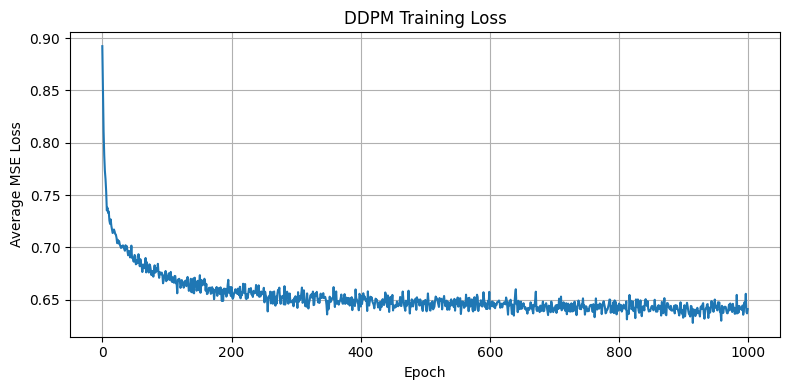

In [41]:
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.title("DDPM Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Average MSE Loss")
plt.grid(True)
plt.tight_layout()
plt.savefig("ddpm_training_loss.pdf")
plt.show()


In [42]:
@torch.no_grad()
def sample_ddpm(model, n_samples=3, seq_len=60):
    model.eval()
    x = torch.randn(n_samples, seq_len, 1).to(device)

    for t in reversed(range(timesteps)):
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]

        predicted_noise = model(x)

        coef1 = 1 / torch.sqrt(alpha_t)
        coef2 = (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)
        mean = coef1 * (x - coef2 * predicted_noise)

        if t > 0:
            noise = torch.randn_like(x)
            sigma = torch.sqrt(beta_t)
            x = mean + sigma * noise
        else:
            x = mean

    return x.cpu()


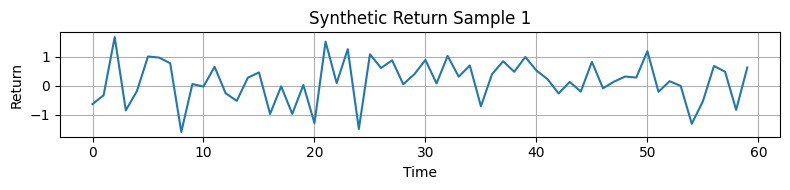

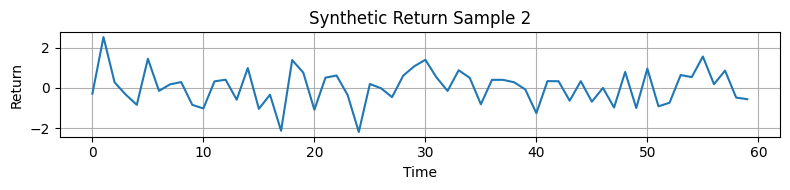

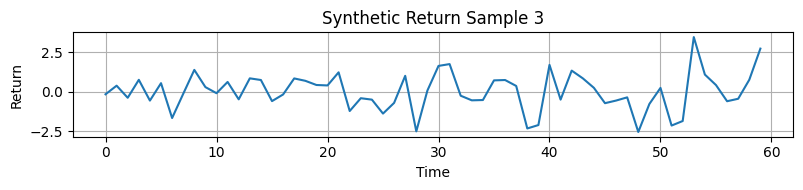

In [43]:
# Generate 3 synthetic return sequences
samples = sample_ddpm(model, n_samples=3)

# Plot
for i, seq in enumerate(samples):
    plt.figure(figsize=(8, 2))
    plt.plot(seq.numpy())
    plt.title(f"Synthetic Return Sample {i+1}")
    plt.xlabel("Time")
    plt.ylabel("Return")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


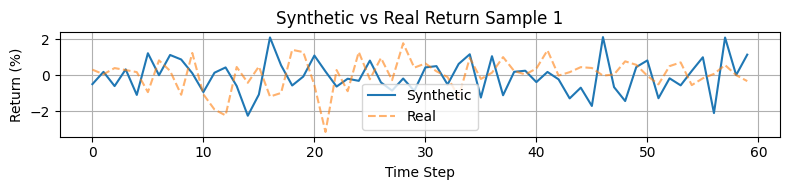

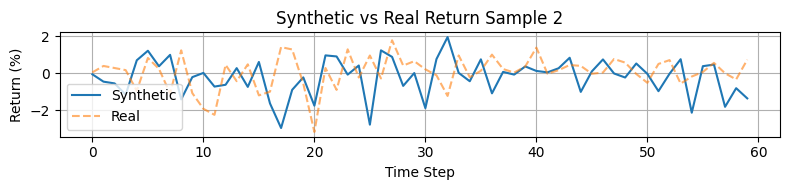

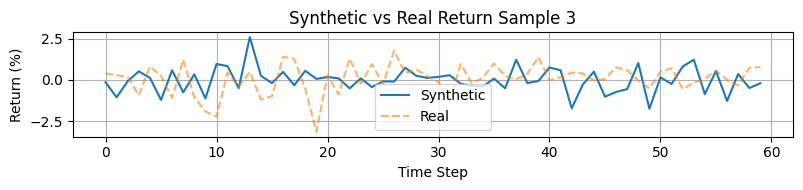

In [44]:
# Generate 3 synthetic return sequences
samples = sample_ddpm(model, n_samples=3)

# Plot synthetic vs real
for i, seq in enumerate(samples):
    plt.figure(figsize=(8, 2))
    plt.plot(seq.numpy(), label='Synthetic')
    plt.plot(X[i].squeeze(), label='Real', linestyle='--', alpha=0.6)
    plt.title(f"Synthetic vs Real Return Sample {i+1}")
    plt.xlabel("Time Step")
    plt.ylabel("Return (%)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"comparison_sample_{i+1}.pdf")
    plt.show()


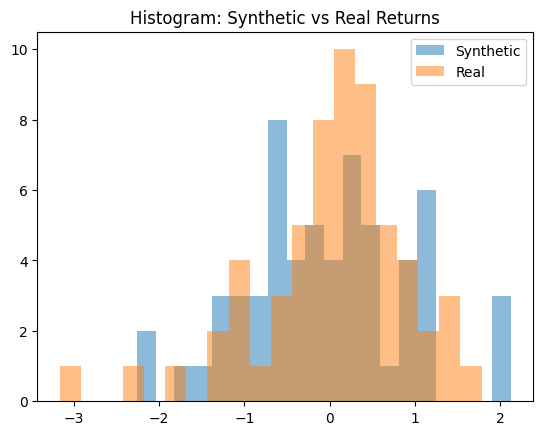

In [45]:
plt.hist(samples[0].numpy(), bins=20, alpha=0.5, label='Synthetic')
plt.hist(X[0].squeeze(), bins=20, alpha=0.5, label='Real')
plt.title('Histogram: Synthetic vs Real Returns')
plt.legend()
plt.show()


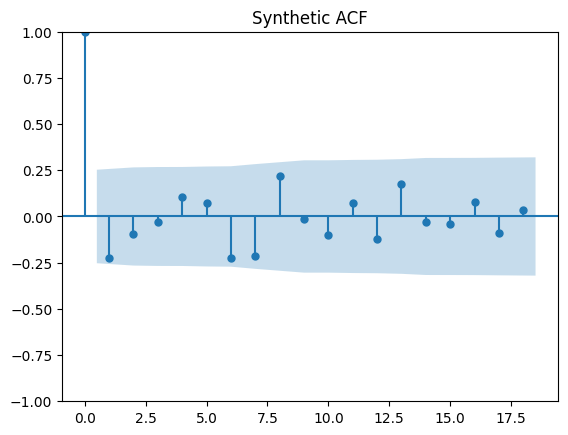

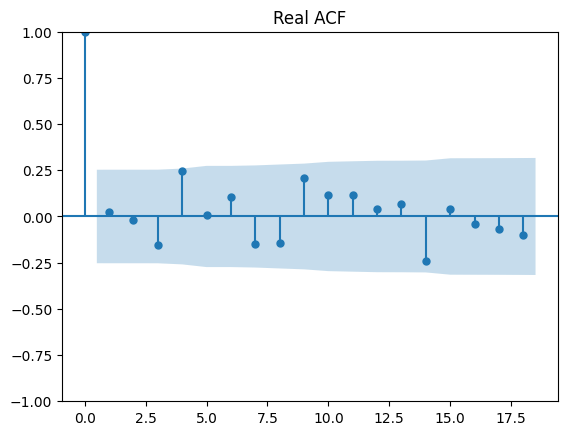

In [46]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(samples[0].numpy(), title="Synthetic ACF")
plot_acf(X[0].squeeze(), title="Real ACF")
plt.show()


In [47]:
import scipy.stats as stats

def summary_stats(x):
    return {
        'Mean': np.mean(x),
        'Std': np.std(x),
        'Skew': stats.skew(x),
        'Kurtosis': stats.kurtosis(x)
    }

print("Synthetic:", summary_stats(samples[0].numpy()))
print("Real:", summary_stats(X[0].squeeze()))


Synthetic: {'Mean': np.float32(-0.050505262), 'Std': np.float32(0.9599954), 'Skew': array([0.11158235]), 'Kurtosis': array([-0.10703015], dtype=float32)}
Real: {'Mean': np.float64(0.052760582131520226), 'Std': np.float64(0.8906050092021832), 'Skew': np.float64(-1.0234502608697875), 'Kurtosis': np.float64(1.9560999091700824)}


In [48]:
import pandas as pd
import scipy.stats as stats

def summary_stats(x):
    return {
        'Mean': np.mean(x),
        'Std Dev': np.std(x),
        'Skewness': stats.skew(x),
        'Kurtosis': stats.kurtosis(x)
    }

# Compute stats for the first synthetic and real sample
synthetic_stats = summary_stats(samples[0].numpy())
real_stats = summary_stats(X[0].squeeze())

# Combine into a DataFrame
stats_df = pd.DataFrame([synthetic_stats, real_stats], index=["Synthetic", "Real"])
print(stats_df)

# Optional: save as LaTeX or CSV for your thesis
stats_df.to_latex("summary_stats_table.tex")
stats_df.to_csv("summary_stats_table.csv")


               Mean   Std Dev               Skewness       Kurtosis
Synthetic -0.050505  0.959995  [0.11158234626054764]  [-0.10703015]
Real       0.052761  0.890605               -1.02345         1.9561


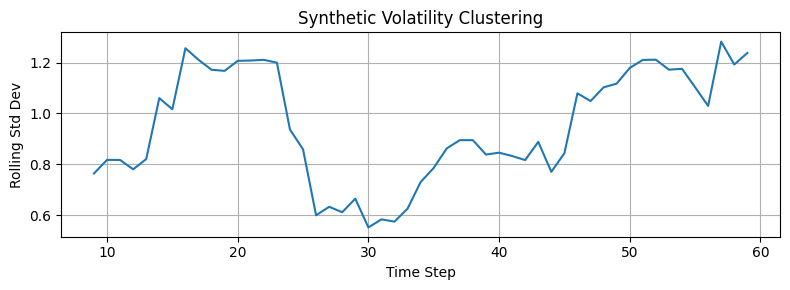

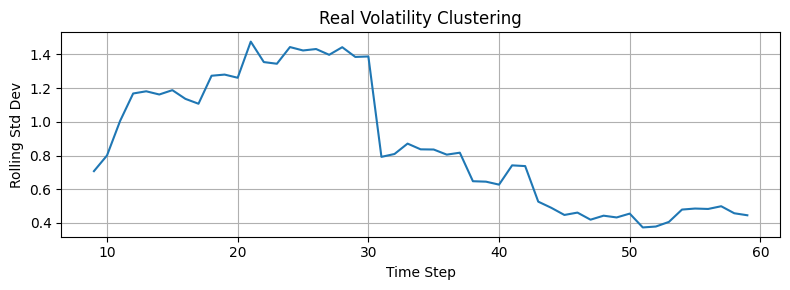

In [49]:
# --- Volatility Clustering Comparison ---

def plot_volatility_cluster(seq, title):
    """
    Plots the rolling standard deviation to visualize volatility clustering.
    """
    rolling_vol = pd.Series(seq.squeeze()).rolling(10).std()
    plt.figure(figsize=(8, 3))
    plt.plot(rolling_vol)
    plt.title(title)
    plt.xlabel("Time Step")
    plt.ylabel("Rolling Std Dev")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot for synthetic and real sequences
plot_volatility_cluster(samples[0].numpy(), "Synthetic Volatility Clustering")
plot_volatility_cluster(X[0].squeeze(), "Real Volatility Clustering")


In [50]:
n_samples = 1000  # You can adjust to 100 if you want faster results
synthetic = sample_ddpm(model, n_samples=n_samples).numpy()  # shape: (n_samples, 60)


In [51]:
real = X[:n_samples].squeeze()  # shape: (n_samples, 60)


In [52]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

def compute_aggregate_stats(data):
    return {
        'Mean': np.mean(data),
        'Std Dev': np.std(data),
        'Skewness': skew(data, axis=None),
        'Kurtosis': kurtosis(data, axis=None)
    }

synthetic_stats = compute_aggregate_stats(synthetic)
real_stats = compute_aggregate_stats(real)

# Create comparison table
df_stats = pd.DataFrame([synthetic_stats, real_stats], index=["Synthetic", "Real"])
print(df_stats)

# Optional: save for thesis
df_stats.to_csv("aggregate_stats_comparison.csv")
df_stats.to_latex("aggregate_stats_comparison.tex")


               Mean   Std Dev  Skewness  Kurtosis
Synthetic  0.034303  0.974109 -0.408109  1.516346
Real       0.049001  1.066092 -0.462213  4.427109


In [53]:
from scipy.stats import ks_2samp

# Flatten both into 1D arrays (all time steps together)
synthetic_flat = synthetic.flatten()
real_flat = real.flatten()

ks_stat, ks_pvalue = ks_2samp(synthetic_flat, real_flat)

print(f"KS Statistic: {ks_stat:.4f}, p-value: {ks_pvalue:.4f}")


KS Statistic: 0.0427, p-value: 0.0000


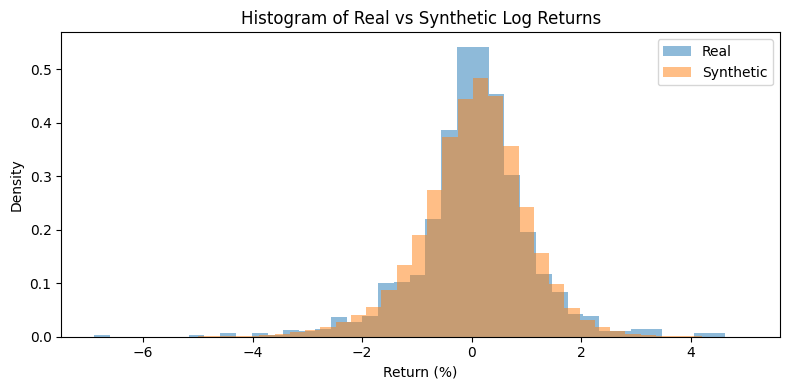

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(real_flat, bins=40, alpha=0.5, label='Real', density=True)
plt.hist(synthetic_flat, bins=40, alpha=0.5, label='Synthetic', density=True)
plt.title("Histogram of Real vs Synthetic Log Returns")
plt.xlabel("Return (%)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.savefig("real_vs_synthetic_histogram.pdf")
plt.show()


## Comprehensive Evaluation Metrics

The following cells add comprehensive evaluation metrics as requested by the supervisor.
This includes automated metrics, plots, and LaTeX table generation.

In [ ]:
# Import evaluation framework
import sys
sys.path.append('../src')
from evaluation_framework import FinancialModelEvaluator

# Initialize evaluator
evaluator = FinancialModelEvaluator(model_names=['DDPM'])
print("✅ Evaluation framework loaded!")

In [ ]:
# Prepare DDPM results for evaluation
# Assuming you have 'samples' from the DDPM generation

# Save DDPM results for comprehensive evaluation
import numpy as np
np.save('../results/ddpm_returns.npy', samples.numpy())

print("✅ DDPM results saved for comprehensive evaluation!")

In [ ]:
# Run comprehensive evaluation for DDPM
real_data = X.flatten()  # Flatten the real training data
synthetic_data_dict = {'DDPM': samples.numpy().flatten()}

results = evaluator.run_comprehensive_evaluation(
    real_data=real_data,
    synthetic_data_dict=synthetic_data_dict,
    save_path="../results/ddpm_evaluation/"
)

print("\n🎉 DDPM comprehensive evaluation completed!")
print("📊 Results saved to: ../results/ddpm_evaluation/")